<a href="https://colab.research.google.com/github/Kaiziferr/machine_learning/blob/main/imbalanced_classification/gmean_metric.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [30]:
import pandas as pd
import numpy as np

from sklearn.datasets import make_classification

from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import train_test_split

from sklearn.metrics import (
    roc_curve,
    roc_auc_score,
    precision_recall_curve,
    f1_score,
    recall_score,
    confusion_matrix,
    f1_score,
    auc)

import warnings

import seaborn as sns
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt
import plotnine
from plotnine import *


In [2]:
def generate_colors(paleta:str="Set1", n_colors:int=15)-> tuple:
  """color generator"""
  try:
    cmap = sns.color_palette(paleta, n_colors).as_hex()
    list_camp = ListedColormap(cmap)
    return cmap, list_camp
  except Exception as e:
    print(e)

def plot_bar(data:pd.DataFrame, paleta:list=None, figsize_x:int=8, figsize_y:int=5,
             fontsize:int=15, **kwards)->None:
  """Grafica un diagrama de barras con multiples caracteristicas"""
  try:
    paleta = paleta if paleta !=None else generate_colors()[0]
    v = kwards
    ejeX = v["ejeX"]

    fig, ax = plt.subplots(figsize = (figsize_x, figsize_y))
    fig.suptitle(f'Diagrama de barras {v["title"]}', fontsize=fontsize)

    if type(ejeX) == str:
      sns.countplot(x=ejeX, data=data, ax = ax, palette=paleta)
    else:
      ejeX = v['ejeX'][0]
      sns.countplot(x=ejeX, hue=v['ejeX'][1], data=data, ax=ax, palette=paleta)

    ax.set_ylabel(v['ejey'], size = 12)
    ax.set_xlabel(ejeX, size=fontsize-3)

    ax.set_xticklabels(ax.get_xticklabels(), fontsize = fontsize-3)
    for p in ax.patches:
      try:
        height = int(p.get_height())
        height_text = height
        if kwards['p'] == True:
          percentage = round(height/data.shape[0], 5)
          height_text = f'{height} ({percentage})'
        ax.text(p.get_x()+p.get_width()/2., height + 1, height_text, ha="center")
      except:
        pass

  except Exception as e:
    print(e)


#**Config**
---


In [3]:
sns.set(style="darkgrid")
pd.set_option('display.float_format', '{:,.2f}'.format)
warnings.simplefilter("ignore")
title_data = 'Clientes del centro comercial'
paleta = sns.color_palette("tab10").as_hex()

# **Data**
---

In [4]:
X, y = make_classification(
    n_samples=10000,
    n_features=5,
    n_redundant=0,
    n_clusters_per_class=1,
    weights=[0.99],
    flip_y=0,
    random_state=12354
    )

In [5]:
y_view = pd.DataFrame(y, columns=['variable_objetivo'])
y_view['variable_objetivo'] = y_view['variable_objetivo'].astype(str)

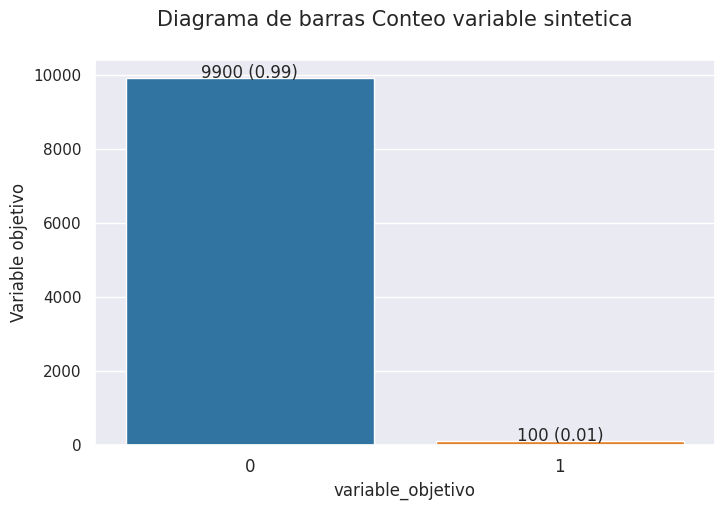

In [6]:
plot_bar(
    y_view,
    ejeX='variable_objetivo',
    ejey= 'Variable objetivo',
    paleta=paleta,
    title='Conteo variable sintetica',
    p=True)

- La presente gráfica visualiza la variable sintética que se generó para el presente estudio, donde se ve que la clase mayoritaria tiene el 99% y la minoritaria es de apenas 1%. Se evidencia un desbalance muy significativo.

- Para cuestiones del estudio, nuestra variable de interés es la clase minoritaria.

# **Split**
---

In [7]:
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    train_size=0.5,
    random_state=12354,
    stratify=y)

Se selecciona un tamaño de la muestra de entrenamiento de 0.6, ya que la data para la clase minoritaria, pero de interés es mínima.

# **Model**
---

- No se considera la estandarizaciones, por que no es necesario

In [8]:
# Primer Modelo
model_tree = DecisionTreeClassifier(
    random_state=12354,
    max_depth=3)
model_tree.fit(X_train, y_train)
y_tree_prediction = model_tree.predict_proba(X_test)
y_tree_prediction = y_tree_prediction[:,1]
auc_tree_score = roc_auc_score(y_test, y_tree_prediction)

In [9]:
# Segundo Modelo
model_log = LogisticRegression(
    random_state=12354,
    solver='lbfgs')
model_log.fit(X_train, y_train)
y_log_prediction = model_log.predict_proba(X_test)
y_log_prediction = y_log_prediction[:, 1]
auc_loc_score = roc_auc_score(y_test, y_log_prediction)

In [10]:
# Modelo no skill
ns_prob = [0 for _ in range(len(y_test))]
auc_noskill_score = roc_auc_score(y_test, ns_prob)
fpr_noskill, tpr_treenoskill, _ = roc_curve(y_test, ns_prob)

# **Metrics**
---

In [11]:
fpr_tree, tpr_tree, thresholds_tree = roc_curve(y_test, y_tree_prediction)
fpr_log, tpr_log, thresholds_log = roc_curve(y_test, y_log_prediction)

In [12]:
# G-MEAN TREE
gmean_tree = np.sqrt(tpr_tree * (1-fpr_tree))
index_tree = np.argmax(gmean_tree)
threshold_opt_tree = round(thresholds_tree[index_tree], ndigits = 4)
gmean_opt_tree = round(gmean_tree[index_tree], ndigits = 4)
fpr_opt_tree = round(fpr_tree[index_tree], ndigits = 4)
tpr_opt_tree = round(tpr_tree[index_tree], ndigits = 4)
print('Best Threshold: {} with G-Mean: {}'.format(threshold_opt_tree, gmean_opt_tree))
print('FPR: {}, TPR: {}'.format(fpr_opt_tree, tpr_opt_tree))

Best Threshold: 0.0141 with G-Mean: 0.9756
FPR: 0.0287, TPR: 0.98


In [13]:
# G-MEAN Log
gmean_log = np.sqrt(tpr_log * (1-fpr_log))
index_log = np.argmax(gmean_log)
threshold_opt_log = round(thresholds_log[index_log], ndigits = 4)
gmean_opt_log = round(gmean_log[index_log], ndigits = 4)
fpr_opt_log = round(fpr_log[index_log], ndigits = 4)
tpr_opt_log = round(tpr_log[index_log], ndigits = 4)
print('Best Threshold: {} with G-Mean: {}'.format(threshold_opt_log, gmean_opt_log))
print('FPR: {}, TPR: {}'.format(fpr_opt_log, tpr_opt_log))

Best Threshold: 0.0665 with G-Mean: 0.9877
FPR: 0.0244, TPR: 1.0


In [14]:
# Youden’s J statistic

youdenJ_score_tree = tpr_tree - fpr_tree
index_tree = np.argmax(youdenJ_score_tree)
threshold_opt_tree = round(thresholds_tree[index_tree], ndigits = 4)
fpr_opt_tree_youdenJ = round(fpr_tree[index_tree], ndigits = 4)
tpr_opt_tree_youdenJ = round(tpr_tree[index_tree], ndigits = 4)
print(f'Best Threshold: {threshold_opt_tree}')
print(f'FPR: {fpr_opt_tree_youdenJ}, TPR: {tpr_opt_tree_youdenJ}')


youdenJ_score_log = tpr_log -fpr_log
index_log = np.argmax(youdenJ_score_log)
threshold_opt_log = round(thresholds_log[index_log], ndigits = 4)
fpr_opt_log_youdenJ = round(fpr_log[index_log], ndigits = 4)
tpr_opt_log_youdenJ = round(tpr_log[index_log], ndigits = 4)
print(f'Best Threshold: {threshold_opt_log}')
print('FPR: {}, TPR: {}'.format(fpr_opt_log_youdenJ, tpr_opt_log_youdenJ))

Best Threshold: 0.0141
FPR: 0.0287, TPR: 0.98
Best Threshold: 0.0665
FPR: 0.0244, TPR: 1.0


# **ROC**
---

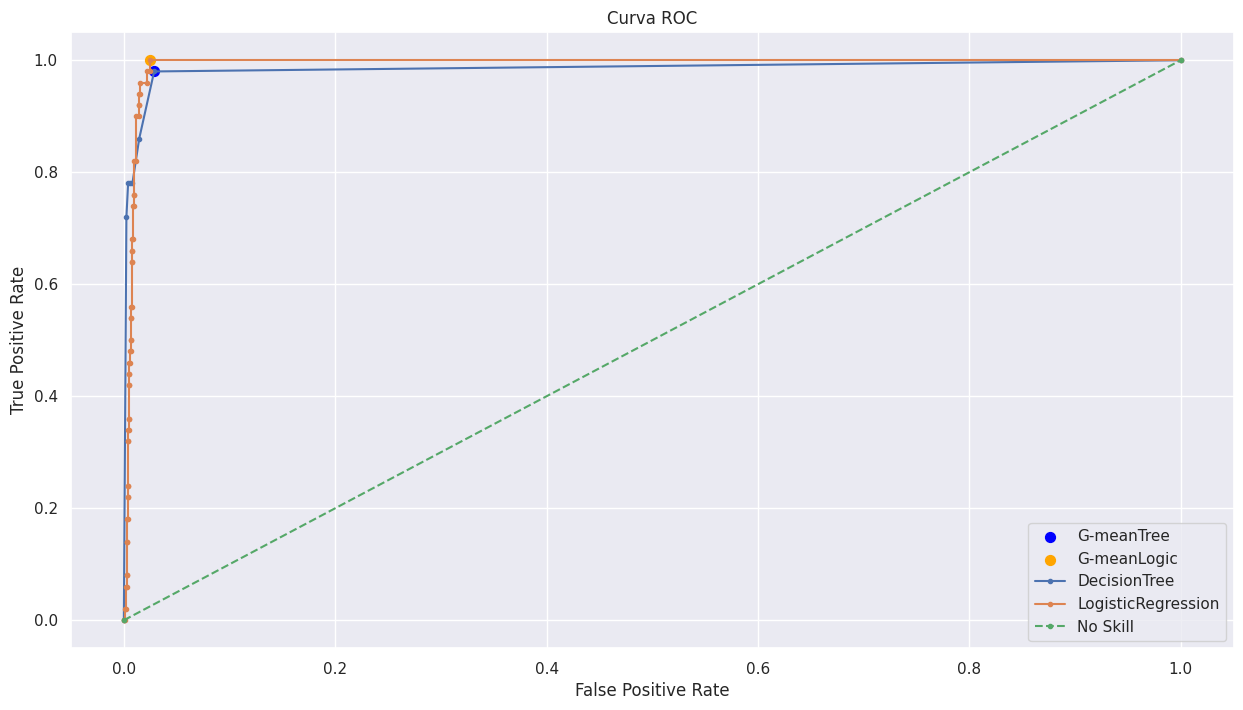

In [15]:
fig, ax = plt.subplots(figsize=(15, 8))
plt.scatter(fpr_opt_tree, tpr_opt_tree, marker='o', color='blue', s=50, label='G-meanTree')
plt.scatter(fpr_opt_log, tpr_opt_log, marker='o', color='orange', s=50, label='G-meanLogic')
plt.plot(fpr_tree, tpr_tree,  marker='.', label='DecisionTree')
plt.plot(fpr_log, tpr_log,  marker='.', label='LogisticRegression')
plt.plot(fpr_noskill, tpr_treenoskill, marker='.', linestyle='--', label='No Skill')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Curva ROC')
plt.legend()
plt.show()

El índice J de Youden da un resultado del umbral igual al que se utiliza con la media G.

In [16]:
print('No Skill: ROC AUC=%.3f' % (auc_noskill_score))
print('DecisionTree: ROC AUC=%.3f' % (auc_tree_score))
print('Logistic: ROC AUC=%.3f' % (auc_loc_score))

No Skill: ROC AUC=0.500
DecisionTree: ROC AUC=0.985
Logistic: ROC AUC=0.993


En la gráfica y el score del AUC, muestran que el modelo LogisticRegression  que tiene mejor rendimiento en comparación DecisionTree y el modelo sin habilidad. El problema es que aunque el primer modelo tenga mejor rendimiento, probablemente este sobrestimando el problema, ya que es muy probable que sea bueno a la hora de predecir la clase de no interés para el estudio.

Utilizando la media G como métrica de evaluación imparcial y el foco principal del movimiento del umbral, se produce el umbral óptimo para la clasificación binaria en 0.0141 para el modelo DecisionTree y para el modelo Logistic en 0.0665.

la observación se categorizará como clase menor cuando su probabilidad sea inferior a 0.0141 para DecisionTree y para el modelo Logistic en 0.0665.

# **The Precision-Recall curve**
---

In [17]:
precision_tree, recall_tree, thresholds_tree = precision_recall_curve(
    y_test,
    y_tree_prediction
)

In [18]:
precision_log, recall_log, thresholds_log = precision_recall_curve(
    y_test,
    y_log_prediction
)

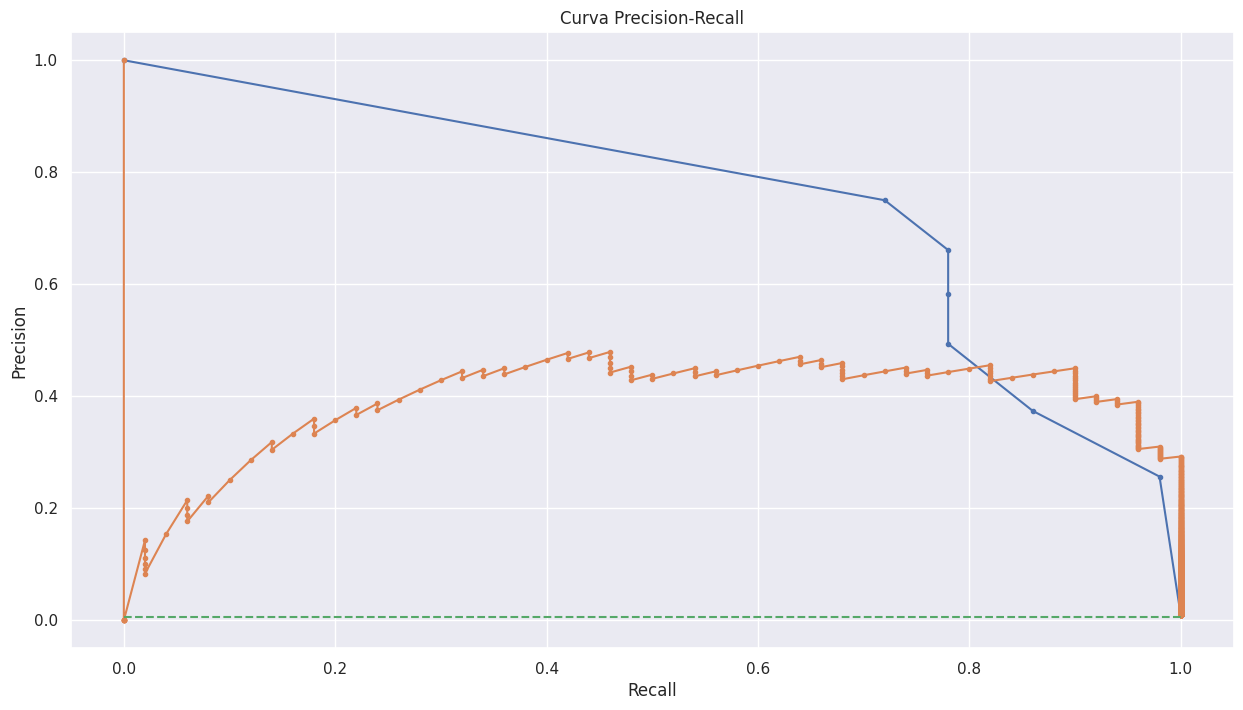

In [39]:
fig, ax = plt.subplots(figsize=(15, 8))
plt.plot(recall_tree, precision_tree, marker='.', label='DecisionTree')
plt.plot(recall_log, precision_log, marker='.', label='LogisticRegression')
no_skill = len(y_test[y_test==1]) / len(y)
plt.plot([0, 1], [no_skill, no_skill], linestyle='--', label='No Skill')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Curva Precision-Recall')
plt.show()

In [33]:
y_tree = model_tree.predict(X_test)
y_log = model_log.predict(X_test)

In [35]:
score_f1_tree, score_auc_tree = f1_score(y_test, y_tree), auc(recall_tree, precision_tree)
score_f1_log, score_auc_log = f1_score(y_test, y_log), auc(recall_log, precision_log)

In [37]:
print(f'The best score f1: {score_f1_tree}')
print(f'AUC: {score_auc_tree}')

The best score f1: 0.7155963302752293
AUC: 0.7475267634486864


In [38]:
print(f'The best score f1: {score_f1_log}')
print(f'AUC: {score_auc_log}')

The best score f1: 0.19178082191780824
AUC: 0.39100410516848666


El modelo que tiene un mejor comportamiento para la detección de la clase minoritaria es el árbol de decisión; sin embargo, ser requerirara más estudios, ya que recordemos que los modelos no están ajustados de la mejor manera.